## 레지스터 토큰이 어떤 기준으로 / 어디에 집중하는 가 연구 

In [2]:
import torch
import numpy as np
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from scipy.ndimage import zoom
from tqdm.notebook import tqdm
from main import VitRGTS
import torch.nn.functional as F
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error


import torch.nn as nn
from torch.optim import Adam

#### 데이터 불러오기


In [3]:
# 1. Setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# 2. Data Preparation
# 사용자 정의 변환: PIL 이미지를 RGB로 변환
def convert_to_rgb(image):
    if image.mode != "RGB":
        image = image.convert("RGB")  # RGBA 또는 P 모드 이미지도 RGB로 변환
    return image

# 변환 구성
transform = transforms.Compose([
    transforms.Lambda(convert_to_rgb),  # RGB로 변환
    transforms.Resize((224, 224)),      # 크기 조정
    transforms.ToTensor(),              # 텐서로 변환
])

# Training data
train_dataset_path = "food_classification/train"
train_dataset = datasets.ImageFolder(root=train_dataset_path, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)

# Validation data
val_dataset_path = "food_classification/validation"
val_dataset = datasets.ImageFolder(root=val_dataset_path, transform=transform)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

# Test data
test_dataset_path = "food_classification/test"
test_dataset = datasets.ImageFolder(root=test_dataset_path, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

#### 모델 초기화

In [4]:
num_register_tokens = 4
num_epochs = 5
patch_size = 16

# 3. Model Initialization
model_with_register = VitRGTS(
    image_size=224,
    patch_size=patch_size,
    num_classes=5,
    dim=256,
    depth=12,
    heads=4,
    mlp_dim=512,
    dropout=0.1,
    num_register_tokens=num_register_tokens,
    use_register_tokens=True
).to(device)

model_without_register = VitRGTS(
    image_size=224,
    patch_size=patch_size,
    num_classes=5,
    dim=256,
    depth=12,
    heads=4,
    mlp_dim=512,
    dropout=0.1,
    use_register_tokens=False
).to(device)

In [5]:
# Loss Function and Optimizer

criterion = nn.CrossEntropyLoss()
optimizer_with_register = Adam(model_with_register.parameters(), lr=0.0002)
optimizer_without_register = Adam(model_without_register.parameters(), lr=0.0002)

In [6]:
# 4. Loss Function and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer_with_register = Adam(model_with_register.parameters(), lr=0.0002, weight_decay=1e-4)
optimizer_without_register = Adam(model_without_register.parameters(), lr=0.0002, weight_decay=1e-4)

def diversity_loss(attn_map, num_register_tokens):
    """
    레지스터 토큰 간의 코사인 유사도를 최소화하는 손실 함수
    Args:
        attn_map: 어텐션 맵 (batch, heads, tokens, tokens)
        num_register_tokens: 레지스터 토큰 개수
    Returns:
        diversity: 레지스터 토큰 간 다양성 손실 값
    """
    register_start_index = attn_map.shape[-1] - num_register_tokens
    reg_attentions = attn_map[:, :, register_start_index:, :]  # (batch, heads, register_tokens, features)
    reg_attentions = reg_attentions.mean(dim=1)  # 헤드 평균 (batch, register_tokens, features)

    # 레지스터 토큰 간 코사인 유사도 계산
    reg_flat = reg_attentions.flatten(start_dim=2)  # (batch, register_tokens, features)
    similarity = torch.nn.functional.cosine_similarity(
        reg_flat[:, :, None], reg_flat[:, None, :], dim=-1
    )  # (batch, register_tokens, register_tokens)

    # 자기 자신 제외한 유사도 평균 계산 (배치별로)
    batch_size = similarity.shape[0]
    diversity = 0
    for b in range(batch_size):
        sim = similarity[b]  # (register_tokens, register_tokens)
        diversity += sim.sum() - sim.diagonal().sum()  # 자기 자신 제외
    diversity /= (batch_size * num_register_tokens * (num_register_tokens - 1))
    return diversity


# 5. Training Function with `tqdm`
def train_model(model, optimizer):
    model.train()
    total_loss = 0
    correct = 0
    for images, labels in tqdm(train_loader, desc="Training", leave=False):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs, attn_maps = model(images)  # 모델 예측 및 Attention Maps 추출
        loss = criterion(outputs, labels)
        if num_register_tokens > 0:  # 레지스터 토큰이 있을 경우
            diversity = diversity_loss(attn_maps[-1], num_register_tokens)
            loss += 0.2 * diversity  # Diversity 손실 추가
        loss.backward()
        optimizer.step()
        total_loss += loss.item()   
        _, predicted = outputs.max(1)
        correct += predicted.eq(labels).sum().item()
    accuracy = correct / len(train_loader.dataset)
    avg_loss = total_loss / len(train_loader)
    return avg_loss, accuracy

# 6. Validation Function with `tqdm`
def validate_model(model):
    model.eval()
    correct = 0
    with torch.no_grad():
        for images, labels in tqdm(val_loader, desc="Validating", leave=False):
            images, labels = images.to(device), labels.to(device)
            outputs, _ = model(images)  # Removed Attention map functionality
            _, predicted = outputs.max(1)
            correct += predicted.eq(labels).sum().item()
    accuracy = correct / len(val_dataset)
    return accuracy

In [7]:
# 7. Training Loop and Performance Comparison
print(f"With Register Token:\n")
for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}/{num_epochs}")
    # Train both models
    loss_with_register, acc_with_register = train_model(model_with_register, optimizer_with_register)

    # Validate both models
    val_acc_with_register = validate_model(model_with_register)

    # Print results for each epoch
    print(f"epoch {epoch+1} : Loss = {loss_with_register:.4f}, Train Acc = {acc_with_register:.4f}, Val Acc = {val_acc_with_register:.4f}")


print(f"\n\nWithout Register Token:\n")
for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}/{num_epochs}")
    # Train both models
    loss_without_register, acc_without_register = train_model(model_without_register, optimizer_without_register)

    # Validate both models
    val_acc_without_register = validate_model(model_without_register)

    # Print results for each epoch
    print(f"epoch {epoch+1} : Loss = {loss_without_register:.4f}, Train Acc = {acc_without_register:.4f}, Val Acc = {val_acc_without_register:.4f}")

With Register Token:

Epoch 1/5


Training:   0%|          | 0/313 [00:00<?, ?it/s]

/opt/anaconda3/envs/vitCv/lib/python3.9/contextlib.py:87: FutureWarning: `torch.backends.cuda.sdp_kernel()` is deprecated. In the future, this context manager will be removed. Please see `torch.nn.attention.sdpa_kernel()` for the new context manager, with updated signature.
  self.gen = func(*args, **kwds)


KeyboardInterrupt: 

In [26]:
# Test Function
def test_model(model):
    model.eval()
    correct = 0
    with torch.no_grad():
        for images, labels in tqdm(test_loader, desc="Testing", leave=False):
            images, labels = images.to(device), labels.to(device)
            outputs, _ = model(images)  
            _, predicted = outputs.max(1)
            correct += predicted.eq(labels).sum().item()
    accuracy = correct / len(test_dataset)
    return accuracy

test_acc_with_register = test_model(model_with_register)
test_acc_without_register = test_model(model_without_register)
print(f"With Register Token - Final Test Accuracy: {test_acc_with_register:.4f}")
print(f"Without Register Token - Final Test Accuracy: {test_acc_without_register:.4f}")

Testing:   0%|          | 0/80 [00:00<?, ?it/s]

/opt/anaconda3/envs/vitCv/lib/python3.9/contextlib.py:87: FutureWarning: `torch.backends.cuda.sdp_kernel()` is deprecated. In the future, this context manager will be removed. Please see `torch.nn.attention.sdpa_kernel()` for the new context manager, with updated signature.
  self.gen = func(*args, **kwds)
/opt/anaconda3/envs/vitCv/lib/python3.9/site-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Testing:   0%|          | 0/80 [00:00<?, ?it/s]

With Register Token - Final Test Accuracy: 0.2174
Without Register Token - Final Test Accuracy: 0.1703


## figure 5

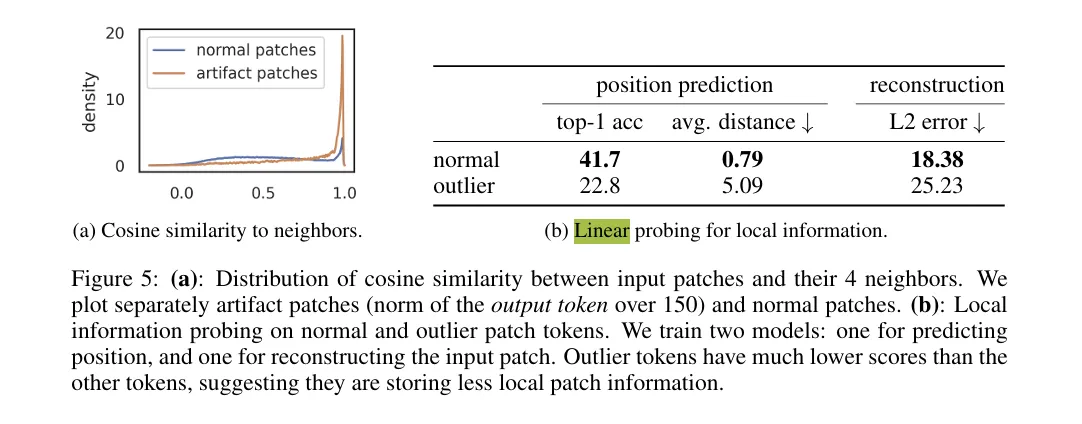


In [12]:
import torch.optim as optim
from sklearn.metrics import accuracy_score
from sklearn.metrics.pairwise import cosine_similarity
import seaborn as sns

### 5a : high-norm token들과 4개의 인접한 패치와의 코사인 유사도 측정

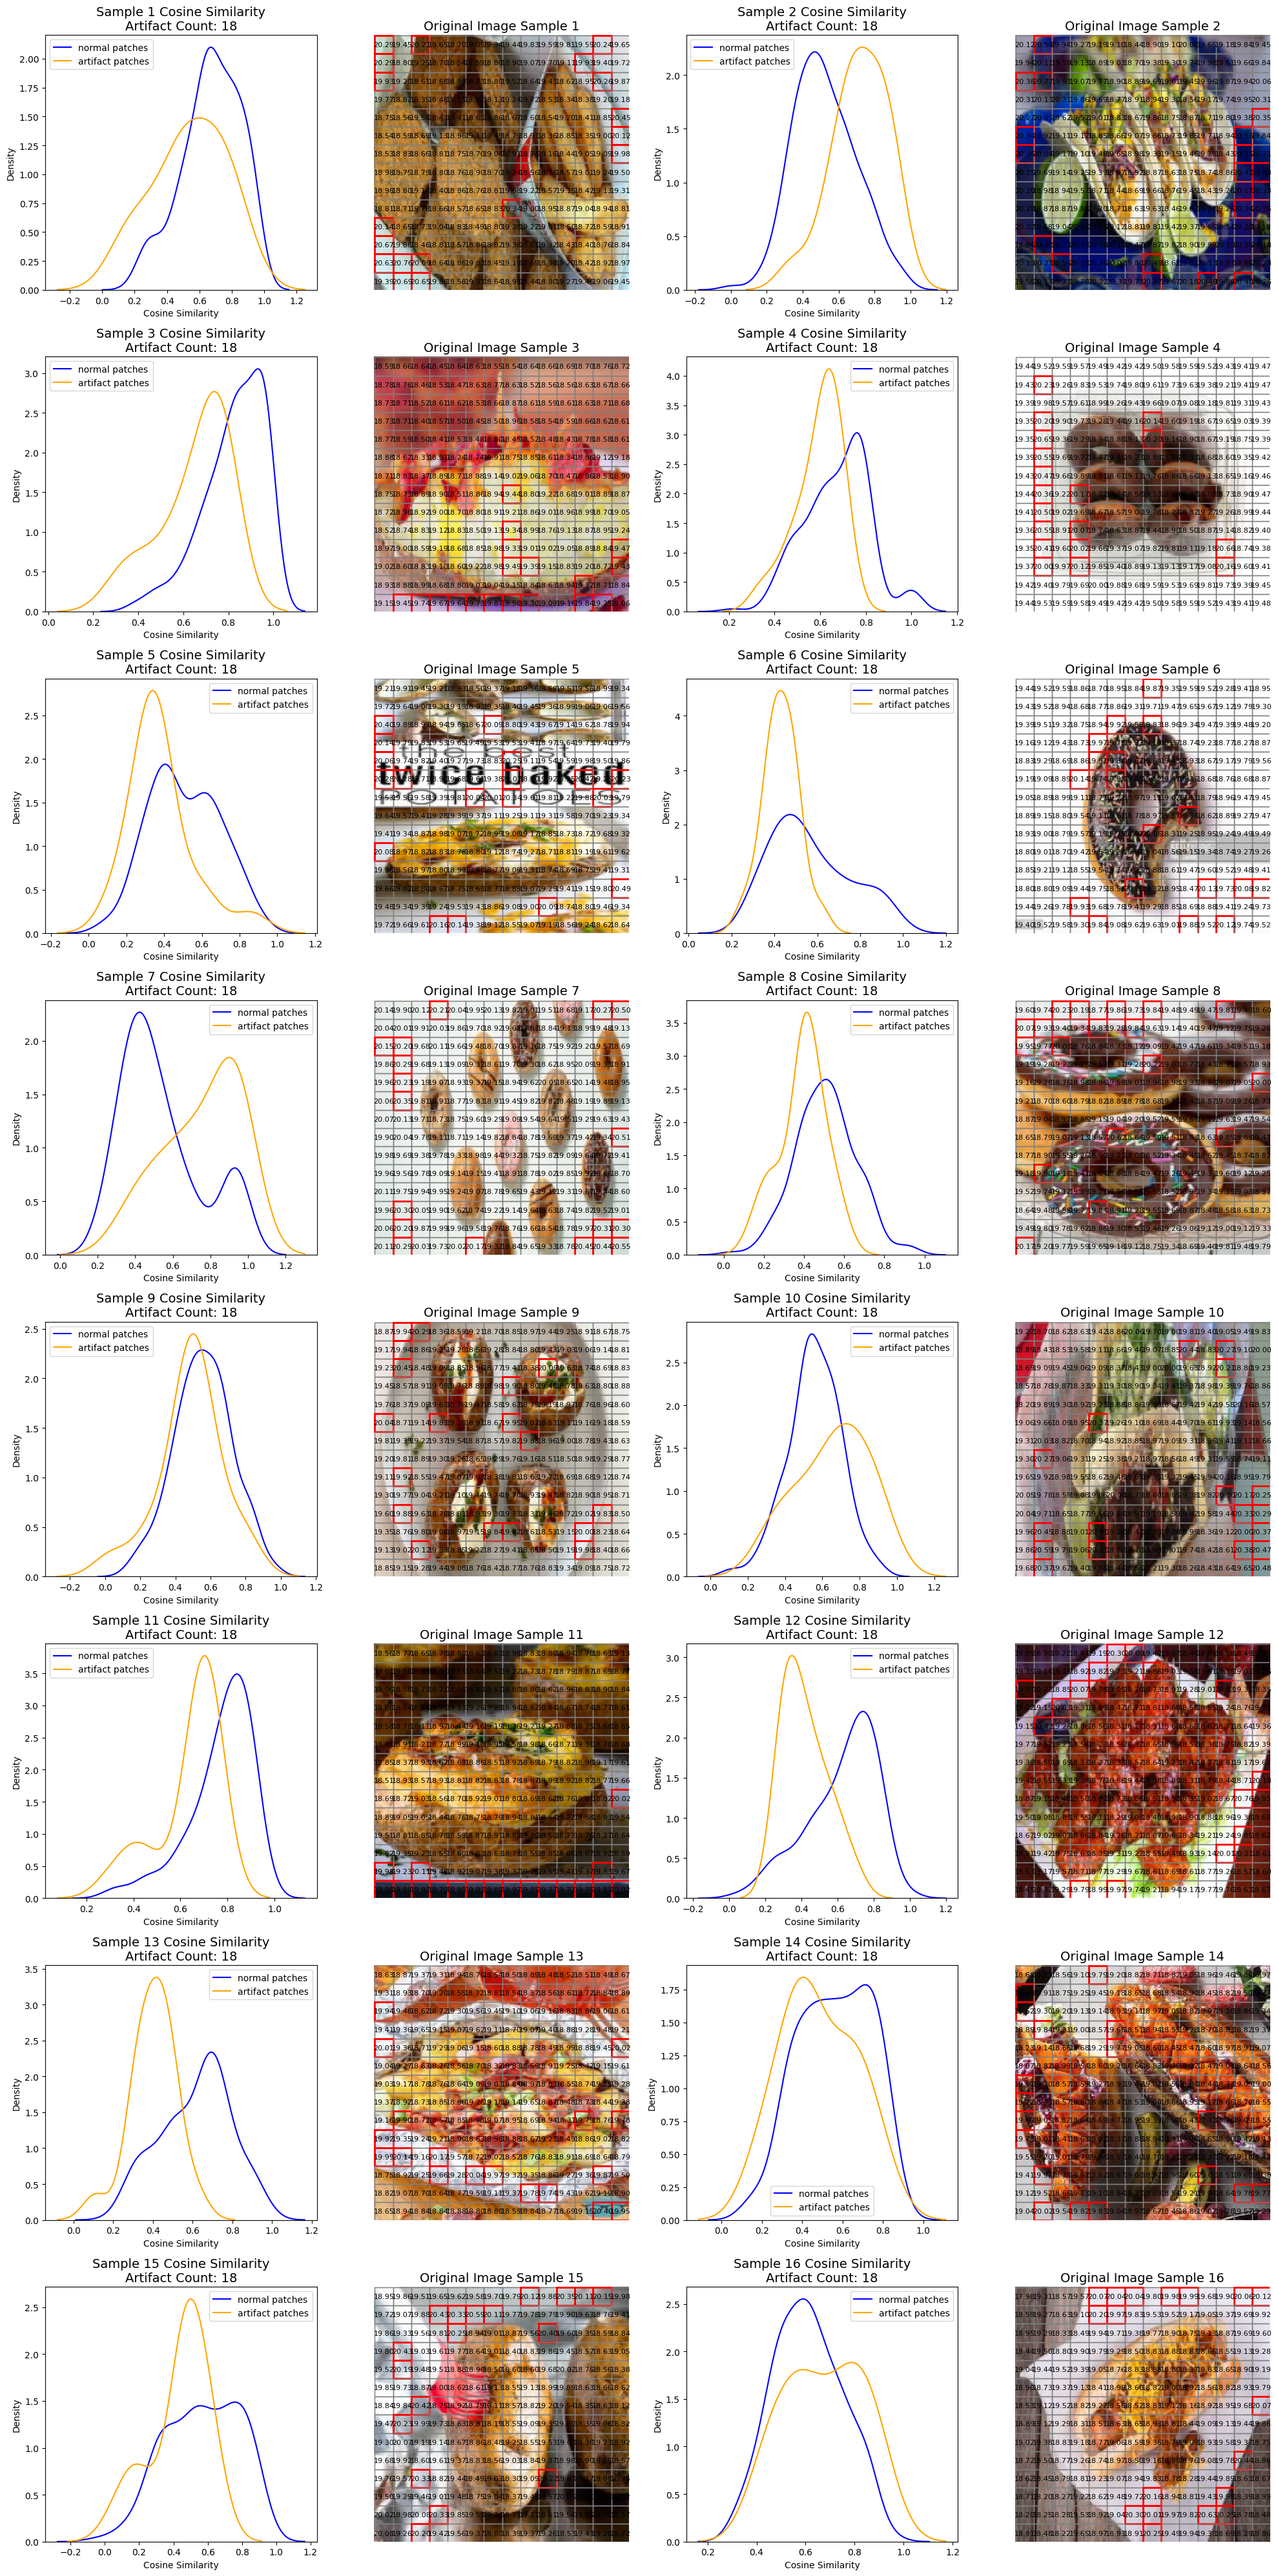

In [ ]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def cosine_similarity(vec1, vec2):
    """벡터 간 코사인 유사도 계산."""
    if vec1.dim() != 1 or vec2.dim() != 1:
        raise ValueError(f"Input vectors must be 1D tensors. Got vec1: {vec1.shape}, vec2: {vec2.shape}")
    return F.cosine_similarity(vec1.unsqueeze(0), vec2.unsqueeze(0), dim=1).item()

def compute_cosine_similarities(patch_embeddings, grid_size):
    """High-norm token과 인접 패치 간 코사인 유사도 계산."""
    normal_similarities = []
    artifact_similarities = []
    artifact_count = 0  # artifact 패치 개수를 세기 위한 변수
    H, W = grid_size

    if patch_embeddings.dim() != 2:
        raise ValueError(f"Expected patch_embeddings to be 2D tensor of shape [Num_patches, Dim], got {patch_embeddings.shape}")

    # 모든 패치의 노름을 계산
    norms = torch.norm(patch_embeddings, dim=1)

    # 상위 5%의 기준값 계산
    threshold_index = int(len(norms) * 0.1)  # 
    threshold_value = torch.topk(norms, threshold_index).values[-1].item()  # 상위 5%의 최소 노름값

    for idx in range(len(patch_embeddings)):
        row, col = divmod(idx, W)  # 1D 인덱스를 2D로 변환
        token = patch_embeddings[idx]  # [Dim] 형태의 단일 벡터
        neighbor_similarities = []

        # 인접 패치 계산
        for dr, dc in [(-1, 0), (1, 0), (0, -1), (0, 1)]:
        
            nr, nc = row + dr, col + dc
            if 0 <= nr < H and 0 <= nc < W:  # 유효한 범위 내
                neighbor_idx = nr * W + nc
                neighbor_token = patch_embeddings[neighbor_idx]  # [Dim] 형태의 단일 벡터
                sim = cosine_similarity(token, neighbor_token)  # 코사인 유사도 계산
                neighbor_similarities.append(sim)

        avg_similarity = np.mean(neighbor_similarities)

        # Norm 기준으로 normal 또는 artifact로 분류
        if norms[idx].item() > threshold_value:  # 상위 5% 기준 설정
            artifact_similarities.append(avg_similarity)
            artifact_count += 1  # artifact 패치 개수 증가
        else:
            normal_similarities.append(avg_similarity)

    return normal_similarities, artifact_similarities, artifact_count, threshold_value  # artifact 개수 반환

# 모델에서 패치 임베딩 추출
model_without_register.eval()
for images, _ in train_loader:
    images = images.to(device)

    with torch.no_grad():
        patch_embeddings = model_without_register.get_patch_embeddings(images)  # [Batch, Num_patches, Dim]

    # High-norm tokens과 코사인 유사도 계산
    grid_size = (14, 14)  # 224x224 이미지에서 패치 크기 16x16일 때
    num_samples = patch_embeddings.size(0)  # 배치 크기

    # 서브플롯 설정
    cols = 2  # 한 줄에 표시할 샘플 수
    rows = (num_samples + cols - 1) // cols  # 필요한 행 수 계산
    fig, axes = plt.subplots(rows, cols * 2, figsize=(cols * 10, rows * 5))  # 그래프와 이미지 각각 2열 설정
    axes = axes.flatten()  # axes를 1D 배열로 변환

    for sample_idx in range(num_samples):  # 배치 내 각 샘플 반복
        sample_embeddings = patch_embeddings[sample_idx]  # [Num_patches, Dim]
        normal_similarities, artifact_similarities, artifact_count, threshold_value = compute_cosine_similarities(
            sample_embeddings, grid_size=grid_size
        )

        # 그래프 생성
        ax = axes[sample_idx * 2]  # 그래프를 위한 서브플롯
        sns.kdeplot(normal_similarities, label="normal patches", color="blue", fill=False, ax=ax)
        sns.kdeplot(artifact_similarities, label="artifact patches", color="orange", fill=False, ax=ax)
        ax.set_title(f"Sample {sample_idx + 1} Cosine Similarity\nArtifact Count: {artifact_count}", fontsize=14)
        ax.set_xlabel("Cosine Similarity")
        ax.set_ylabel("Density")
        ax.legend()

        # 원본 이미지 표시
        original_image = images[sample_idx].cpu().numpy().transpose(1, 2, 0)  # [C, H, W] -> [H, W, C]
        original_image = np.clip(original_image, 0, 1)  # 이미지 범위 조정

        # 이미지 표시
        ax = axes[sample_idx * 2 + 1]  # 이미지 서브플롯
        ax.imshow(original_image)
        ax.set_title(f"Original Image Sample {sample_idx + 1}", fontsize=14)
        ax.axis('off')  # 축 숨기기

        # 패치 노름 값 표시
        patch_size = 16  # 각 패치의 크기
        for idx in range(sample_embeddings.size(0)):  # 모든 패치에 대해
            row, col = divmod(idx, grid_size[1])  # 2D 인덱스 계산
            top_left_y = row * patch_size
            top_left_x = col * patch_size
            
            # 패치의 노름 계산
            norm_value = torch.norm(sample_embeddings[idx]).item()

            # 패치 표시 (사각형 그리기)
            rect = plt.Rectangle((top_left_x, top_left_y), patch_size, patch_size, linewidth=1, edgecolor='gray', facecolor='none')
            ax.add_patch(rect)  # 패치 사각형 추가

            # 노름이 artifact 기준을 초과하면 강조
            if norm_value > threshold_value:  # 상위 5% 기준
                rect.set_edgecolor('red')  # 빨간색으로 강조
                rect.set_linewidth(2)
            
            # 노름 값을 패치 중앙에 표시
            ax.text(top_left_x + patch_size / 2, top_left_y + patch_size / 2, f'{norm_value:.2f}', 
                color='black', ha='center', va='center', fontsize=8)

    # 빈 subplot 처리 (배치 크기가 cols의 배수가 아닌 경우)
    for empty_idx in range(num_samples * 2, len(axes)):
        fig.delaxes(axes[empty_idx])  # 빈 subplot 삭제

    plt.tight_layout()  # 레이아웃 조정
    plt.show()  # 전체 결과 출력
    break  # 첫 번째 배치만 처리


### (b) High-norm tokens은 local information 를 거의 담고 있지 않다. 

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm

# Linear model 정의
class LinearModel(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(LinearModel, self).__init__()
        self.fc = nn.Linear(input_dim, output_dim)

    def forward(self, x):
        return self.fc(x)

def position_prediction(train_loader, input_dim, num_patches):
    model = LinearModel(input_dim, 2)  # x, y 좌표 예측
    optimizer = optim.Adam(model.parameters(), lr=1e-3)
    criterion = nn.MSELoss()

    model.train()
    for batch in tqdm(train_loader, desc="Training Position Prediction"):
        patch_embeddings, labels = batch  # 패치 임베딩과 레이블 로드

        # 모든 패치의 노름 계산
        norms = torch.norm(patch_embeddings, dim=1)
        
        # 상위 10% 필터링
        threshold_value = torch.quantile(norms, 0.9)  # 상위 10% 기준
        high_norm_tokens = (norms > threshold_value).nonzero(as_tuple=True)[0]  # 상위 10% 토큰 인덱스

        if high_norm_tokens.numel() == 0:
            continue  # 다음 배치로 넘어감

        # High-norm 토큰으로 패치 임베딩 필터링
        high_norm_embeddings = patch_embeddings[high_norm_tokens]

        # 레이블 필터링 (위치)
        high_norm_labels = labels[high_norm_tokens]

        # 예측
        optimizer.zero_grad()
        predictions = model(high_norm_embeddings.view(-1, input_dim))  # (number_of_high_norm_tokens, input_dim)

        # 손실 계산
        loss = criterion(predictions, high_norm_labels)  # 레이블과 예측의 형태가 일치해야 함
        loss.backward()
        optimizer.step()

    return model

def pixel_reconstruction(train_loader, input_dim, num_patches, image_shape):
    model = LinearModel(input_dim, image_shape[0] * image_shape[1] * image_shape[2])  # 이미지 픽셀 예측
    optimizer = optim.Adam(model.parameters(), lr=1e-3)
    criterion = nn.MSELoss()

    model.train()
    for batch in tqdm(train_loader, desc="Training Pixel Reconstruction"):
        patch_embeddings, images = batch  # 패치 임베딩과 원본 이미지 로드

        # 모든 패치의 노름 계산
        norms = torch.norm(patch_embeddings, dim=1)
        
        # 상위 10% 필터링
        threshold_value = torch.quantile(norms, 0.9)  # 상위 10% 기준
        high_norm_tokens = (norms > threshold_value).nonzero(as_tuple=True)[0]  # 상위 10% 토큰 인덱스

        if high_norm_tokens.numel() == 0:
            continue  # 다음 배치로 넘어감

        # High-norm 토큰으로 패치 임베딩 필터링
        high_norm_embeddings = patch_embeddings[high_norm_tokens]

        # 레이블 필터링 (픽셀값)
        high_norm_labels = images[high_norm_tokens]  # 이미지의 해당 패치에 대한 픽셀값

        # 예측
        optimizer.zero_grad()
        predictions = model(high_norm_embeddings.view(-1, input_dim))  # (number_of_high_norm_tokens, input_dim)

        # 손실 계산
        loss = criterion(predictions, high_norm_labels.view(-1, image_shape[0] * image_shape[1] * image_shape[2]))  # 레이블과 예측의 형태가 일치해야 함
        loss.backward()
        optimizer.step()

    return model

# 모델에서 패치 임베딩 추출
model_without_register.eval()
for images, _ in train_loader:
    images = images.to(device)

    with torch.no_grad():
        patch_embeddings = model_without_register.get_patch_embeddings(images)  # [Batch, Num_patches, Dim]

    # input_dim과 num_patches 정의
    input_dim = patch_embeddings.size(2)  # 패치 임베딩의 차원
    num_patches = patch_embeddings.size(1)  # 각 이미지의 패치 개수

    # Task1: Position Prediction
    position_model = position_prediction(train_loader, input_dim, num_patches)

    # Task2: Pixel Reconstruction
    pixel_model = pixel_reconstruction(train_loader, input_dim, num_patches, images.shape[1:])


Training Position Prediction:   0%|          | 0/313 [00:00<?, ?it/s]